In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
import numpy as np

In [50]:
def plot_subplot(ax, gdf, subtitle, color_col, cmap_name, colors_index, size_col, size_type='max_distance'):

    ax.set_extent([98, 127, 18, 47], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE, lw=1)
    ax.add_feature(cfeature.BORDERS, linestyle=':', lw=1)
    ax.add_feature(cfeature.LAKES, alpha=1)
    ax.add_feature(cfeature.RIVERS, lw=1, zorder=0)

    if size_type == 'match_level':
        unique_match_levels = ['County', 'Prefecture', 'Province']
        size_mapping = {level: (i + 1) * 35 for i, level in enumerate(unique_match_levels)}
        gdf.loc[:, 'size'] = gdf[size_col].map(size_mapping)
    elif size_type == 'max_distance':
        gdf.loc[:, 'size'] = gdf['Maximum Error Distance'] / 1.5
    cmap = plt.colormaps.get_cmap(cmap_name)

    gdf = gdf.loc[:, :].sort_values(by=['state'], ascending=False)
    
    for _, row in gdf.iterrows():
        color = cmap(colors_index.get(row[color_col], 0))
        if size_type == 'match_level':
            size = size_mapping.get(row[size_col], 40)
        elif size_type == 'max_distance':
            size = row['size']
        ax.scatter(row.geometry.x, row.geometry.y, color=color, edgecolor='black', linewidth=1, s=size, alpha=0.8, transform=ccrs.PlateCarree())

    # legend for state
    state_legend = [mlines.Line2D([], [], color=cmap(colors_index[state]), marker='o', 
                                  linestyle='None', markersize=10,
                                  markeredgecolor='black', markeredgewidth=1,
                                  label=state) for state in gdf[color_col].unique()]
    legend1 = ax.legend(handles=state_legend, title='State', fontsize=12, loc='upper left',
                        title_fontsize=12,
                        fancybox=False, edgecolor='black')
    legend1.get_frame().set_linewidth(1)
    legend1.get_title().set_ha('center')

    ax.add_artist(legend1)

    if size_type == 'match_level':
        # legend for match level as uncertainty
        ml_legend = [mlines.Line2D([], [], color='white', marker='o', 
                                markerfacecolor='white', markeredgecolor='black',
                                markeredgewidth=1,
                                linestyle='None', markersize=size/9, label=level) for level, size in size_mapping.items()]
    elif size_type == 'max_distance':
        legend_sizes = [50, 100, 150]
        ml_legend = [mlines.Line2D([], [], color='white', marker='o', 
                                   markerfacecolor='white', markeredgecolor='black',
                                   markeredgewidth=1,
                                   linestyle='None',
                                   markersize=np.sqrt(size),
                                   label=str(size) + ' km')
                        for size in legend_sizes]

    legend2 = ax.legend(handles=ml_legend, title='Maximum\nError Distance', fontsize=12, loc='upper right',
                        title_fontsize=12,
                        fancybox=False, edgecolor='black')
    legend2.get_frame().set_linewidth(1)
    legend2.get_title().set_ha('center')
    ax.add_artist(legend2)

In [51]:
# Read the CSV file
df_chgc_early = pd.read_csv('./data/CHGC-Early.csv', encoding='utf-8-sig')

# Convert geometry column from WKT string to geometric object
df_chgc_early['geometry'] = df_chgc_early['geometry'].apply(lambda x: wkt.loads(x) if isinstance(x, str) else None)

# Create a GeoDataFrame
gdf_chgc_early = gpd.GeoDataFrame(df_chgc_early, geometry='geometry', crs="EPSG:4326")
gdf_chgc_early.dropna(subset=['geometry'], inplace=True)

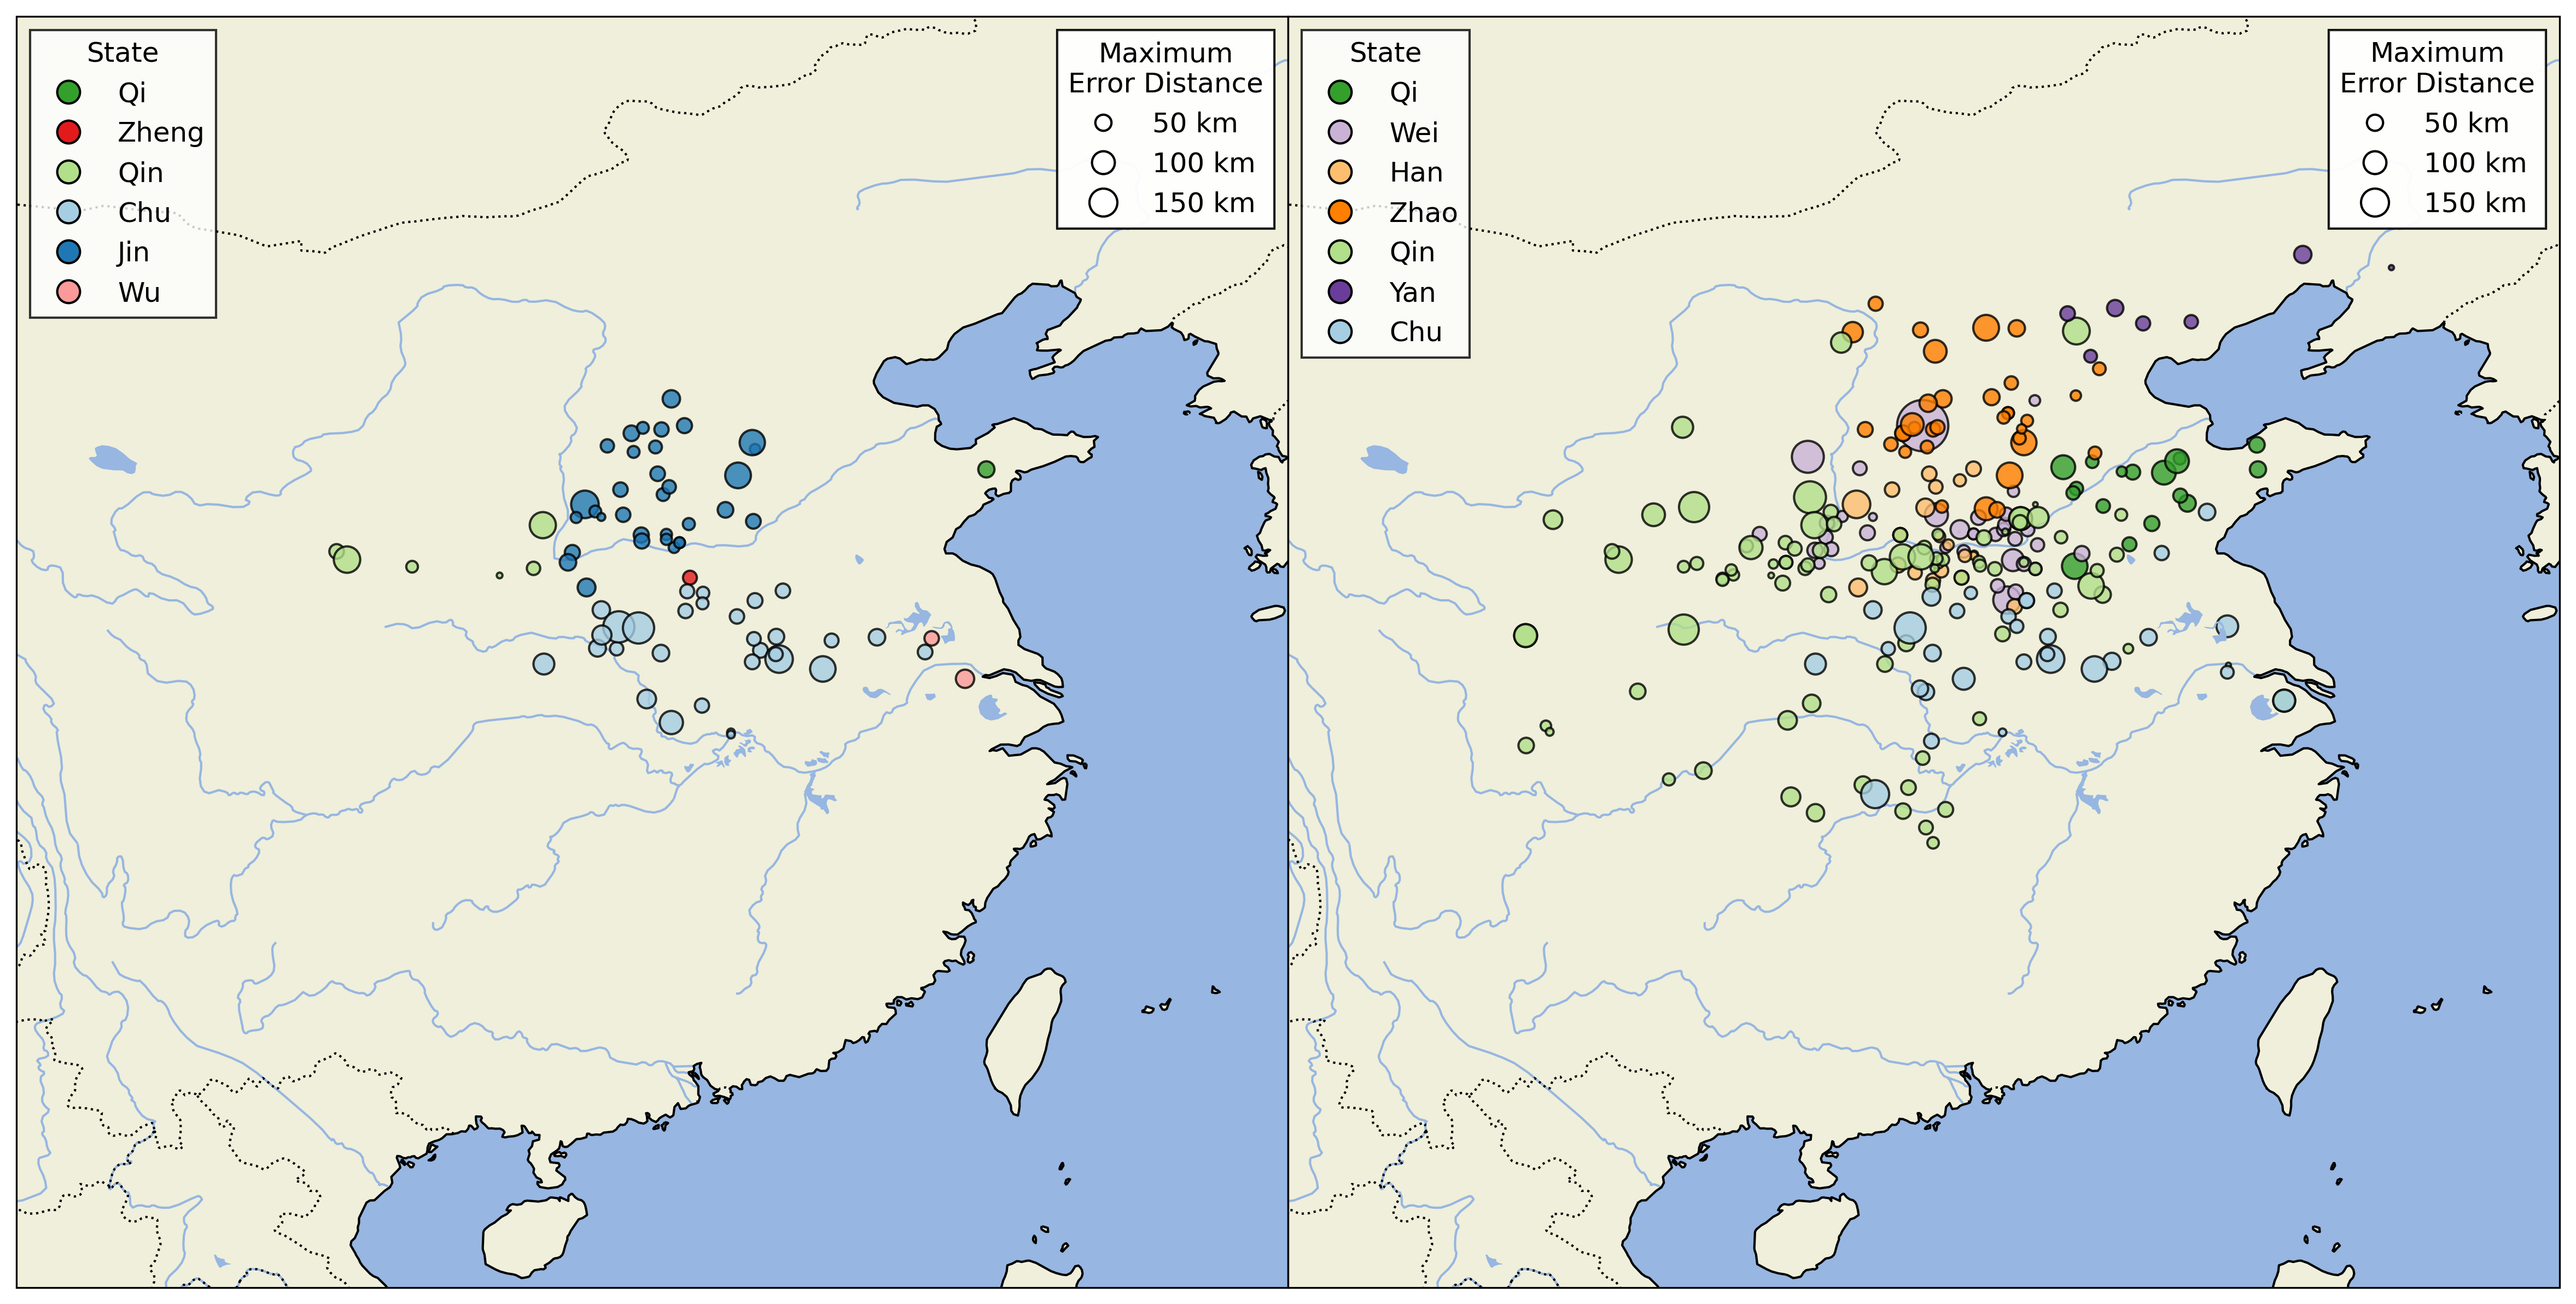

In [52]:
# Set the mapping dictionary for state names
mapping_dict = {
    '齐': 'Qi', '齐（含宋）': 'Qi',
    '楚': 'Chu', '楚（含吴、越）': 'Chu',
    '燕': 'Yan', 
    '韩（含郑）': 'Han', 
    '赵（含中山）': 'Zhao',
    '魏（含卫）': 'Wei', 
    '秦': 'Qin', '秦（含周）': 'Qin',
    '晋': 'Jin', '吴': 'Wu', '郑': 'Zheng', 
    
}
gdf_chgc_early['state_en'] = df_chgc_early['state'].map(mapping_dict)
gdf_chgc_early.dropna(subset=['state_en'], inplace=True)

# Create a dictionary for colors
colors_index = {}
for i, state in enumerate(gdf_chgc_early['state_en'].unique()):
    colors_index[state] = i

# Create two GeoDataFrames for the Spring and Autumn Period and the Warring States Period
gdf_as = gdf_chgc_early[gdf_chgc_early['period'] == 'Spring and Autumn Period'].copy()
gdf_wz = gdf_chgc_early[gdf_chgc_early['period'] == 'Warring States Period'].copy()

# Plot the two GeoDataFrames
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 12), dpi=300, subplot_kw={'projection': ccrs.PlateCarree()})
plt.subplots_adjust(wspace=0)

cmap_name = 'Paired'
ax1 = plot_subplot(ax1, gdf_as, 'Spring and Autumn Period', 'state_en', cmap_name, colors_index, 'Maximum Error Distance', 'max_distance')
ax2 = plot_subplot(ax2, gdf_wz, 'Warring States Period', 'state_en', cmap_name, colors_index, 'Maximum Error Distance', 'max_distance')

plt.show()